<a href="https://colab.research.google.com/github/JossySoo/natural_language_processing_excercises/blob/main/Desafio_3/3_modelo_lenguaje_char.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Ejemplo brindado en la cursada

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' en el año 1872, la casa número 7 de saville-row, burlington gardens \r\n—donde murió sheridan en 1814— estaba habitada por phileas fogg, quien a\r\n pesar de que parecía haber tomado el partido de no hacer nada que \r\npudiese llamar la atención, era uno de los miembros más notables y \r\nsingulares del reformclub de londres. por consiguiente, phileas fogg, personaje enigmático y del cual sólo \r\nse sabía que era un hombre muy galante y de los más cumplidos gentlemen \r\nde la alta sociedad inglesa, sucedía a uno de los más grandes oradores \r\nque honran a inglaterra. decíase que se daba un aire a lo byron —su cabeza, se entiende, \r\nporque, en cuanto a los pies, no tenía defecto alguno—, pero a un byron \r\nde bigote y pastillas, a un byron impasible, que hubiera vivido mil años\r\n sin envejecer. phileas fogg, era inglés de pura cepa; pero quizás no había nacido en\r\n londres. jamás se le había visto en la bolsa ni en el banco, ni en \r\nninguno de los despachos mercantiles de 

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

68

In [9]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [10]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [11]:
tokenized_text[:1000]

[38,
 30,
 61,
 38,
 30,
 34,
 38,
 42,
 21,
 35,
 38,
 60,
 54,
 25,
 1,
 56,
 38,
 34,
 42,
 38,
 16,
 42,
 10,
 42,
 38,
 61,
 8,
 43,
 30,
 57,
 35,
 38,
 25,
 38,
 20,
 30,
 38,
 10,
 42,
 44,
 11,
 34,
 34,
 30,
 63,
 57,
 35,
 13,
 56,
 38,
 29,
 33,
 57,
 34,
 11,
 61,
 41,
 62,
 35,
 61,
 38,
 41,
 42,
 57,
 20,
 30,
 61,
 10,
 38,
 12,
 53,
 28,
 20,
 35,
 61,
 20,
 30,
 38,
 43,
 33,
 57,
 11,
 47,
 38,
 10,
 48,
 30,
 57,
 11,
 20,
 42,
 61,
 38,
 30,
 61,
 38,
 60,
 54,
 60,
 14,
 28,
 38,
 30,
 10,
 62,
 42,
 29,
 42,
 38,
 48,
 42,
 29,
 11,
 62,
 42,
 20,
 42,
 38,
 26,
 35,
 57,
 38,
 26,
 48,
 11,
 34,
 30,
 42,
 10,
 38,
 66,
 35,
 41,
 41,
 56,
 38,
 23,
 33,
 11,
 30,
 61,
 38,
 42,
 12,
 53,
 38,
 26,
 30,
 10,
 42,
 57,
 38,
 20,
 30,
 38,
 23,
 33,
 30,
 38,
 26,
 42,
 57,
 30,
 16,
 18,
 42,
 38,
 48,
 42,
 29,
 30,
 57,
 38,
 62,
 35,
 43,
 42,
 20,
 35,
 38,
 30,
 34,
 38,
 26,
 42,
 57,
 62,
 11,
 20,
 35,
 38,
 20,
 30,
 38,
 61,
 35,
 38,
 48,
 42,
 16,
 3

### Organizando y estructurando el dataset

In [12]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [13]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [14]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [15]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [16]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
X.shape

(359671, 100)

In [18]:
X[0,:10]

array([38, 30, 61, 38, 30, 34, 38, 42, 21, 35])

In [19]:
y[0,:10]

array([30, 61, 38, 30, 34, 38, 42, 21, 35, 38])

In [20]:
vocab_size = len(chars_vocab)

## Definiendo el modelo

In [21]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [22]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 68)          0         
 ributed)                                                        
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 200)         53800     
                                                                 
 dense (Dense)               (None, None, 68)          13668     
                                                                 
Total params: 67468 (263.55 KB)
Trainable params: 67468 (263.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [3]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [24]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1405/1405 [==============================] - ETA: 0s - loss: 2.2021
 mean perplexity: 6.265766191941687 

Saved new model!
1405/1405 [==============================] - 193s 134ms/step - loss: 2.2021
Epoch 2/20
1405/1405 [==============================] - ETA: 0s - loss: 1.8939
 mean perplexity: 5.415703161029827 

Saved new model!
1405/1405 [==============================] - 188s 134ms/step - loss: 1.8939
Epoch 3/20
1405/1405 [==============================] - ETA: 0s - loss: 1.8110
 mean perplexity: 5.104776282061051 

Saved new model!
1405/1405 [==============================] - 172s 122ms/step - loss: 1.8110
Epoch 4/20
1405/1405 [==============================] - ETA: 0s - loss: 1.7729
 mean perplexity: 4.958780917197492 

Saved new model!
1405/1405 [==============================] - 171s 122ms/step - loss: 1.7729
Epoch 5/20
1405/1405 [==============================] - ETA: 0s - loss: 1.7503
 mean perplexity: 4.828548139198175 

Saved new model!
1405/1405 [===============

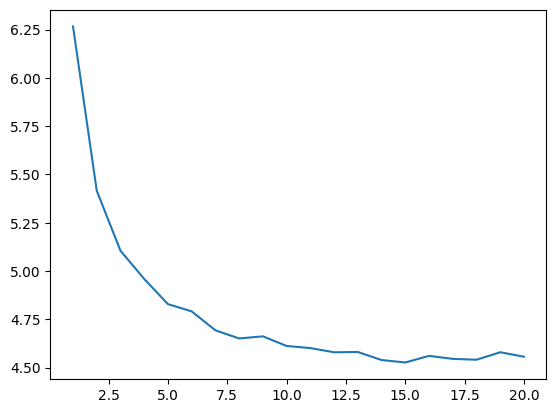

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [26]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')


### Predicción del próximo caracter

In [33]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.4 MB/s

In [28]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://3e66e19b68fec4271e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 23ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3e66e19b68fec4271e.gradio.live


### Generación de secuencias

In [29]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [30]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habia una vez en el capitán de la marcha de'

###  Beam search y muestreo aleatorio

In [48]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [49]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [33]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="habia una vez")

In [34]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 48, 42, 29, 11, 42, 38, 33, 61, 42, 38, 44, 30, 17, 38, 23,
       33, 30, 38, 10, 30, 38, 48, 42, 29, 18, 42, 38, 30, 10, 62, 42, 29,
       42])

In [35]:
# veamos las salidas
decode(salidas[0])

'üüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüühabia una vez que se había estaba'

# Desarrollo del desafío

## Cargar corpus

In [4]:
import os
import platform

In [5]:
# Verifica si el archivo PDF ya está descargado
if os.access('./Jane Austen - Orgullo y Prejuicio.pdf', os.F_OK) is False:
    # Verifica si el archivo PDF ya está descargado
    if os.access('orgullo_y_prejuicio.pdf', os.F_OK) is False:
        # Descargar el archivo según el sistema operativo
        if platform.system() == 'Windows':
            !curl -L -o orgullo_y_prejuicio.pdf https://github.com/JossySoo/natural_language_processing_excercises/raw/main/Data/Jane%20Austen%20-%20Orgullo%20y%20Prejuicio.pdf
        else:
            !wget -O orgullo_y_prejuicio.pdf https://github.com/JossySoo/natural_language_processing_excercises/raw/main/Data/Jane%20Austen%20-%20Orgullo%20y%20Prejuicio.pdf
else:
    print("El PDF ya se encuentra descargado")

--2024-07-03 22:58:42--  https://github.com/JossySoo/natural_language_processing_excercises/raw/main/Data/Jane%20Austen%20-%20Orgullo%20y%20Prejuicio.pdf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JossySoo/natural_language_processing_excercises/main/Data/Jane%20Austen%20-%20Orgullo%20y%20Prejuicio.pdf [following]
--2024-07-03 22:58:42--  https://raw.githubusercontent.com/JossySoo/natural_language_processing_excercises/main/Data/Jane%20Austen%20-%20Orgullo%20y%20Prejuicio.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609042 (595K) [application/octet-stream]
Saving to: ‘orgullo_y_prejui

In [6]:
print("Tamaño del archivo descargado:", os.path.getsize("orgullo_y_prejuicio.pdf"), "bytes")

Tamaño del archivo descargado: 609042 bytes


In [7]:
!pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 54.8 MB/s eta 0:00:00


In [8]:
import fitz  # PyMuPDF

# Leer el PDF y extraer el texto
pdf_document = "orgullo_y_prejuicio.pdf"
doc = fitz.open(pdf_document)
text = ""
for page_num in range(doc.page_count):
    page = doc.load_page(page_num)
    text += page.get_text()

# Mostrar el texto extraído (opcional)
print(text[:1000])  # Muestra los primeros 1000 caracteres

# Guardar el texto extraído en un archivo de texto
with open("orgullo_y_prejuicio.txt", "w", encoding="utf-8") as text_file:
    text_file.write(text)

Orgullo y Prejuicio
Jane Austen
textos.info
Biblioteca digital abierta
1
Texto núm. 3006
Título: Orgullo y Prejuicio
Autor: Jane Austen
Etiquetas: Novela
Editor: Edu Robsy
Fecha de creación: 7 de noviembre de 2017
Fecha de modificación: 7 de noviembre de 2017
Edita textos.info
Maison Carrée
c/ Ramal, 48
07730 Alayor - Menorca
Islas Baleares
España
Más textos disponibles en http://www.textos.info
2
Capítulo I
Es una verdad mundialmente reconocida que un hombre soltero, poseedor 
de una gran fortuna, necesita una esposa.
Sin embargo, poco se sabe de los sentimientos u opiniones de un hombre 
de tales condiciones cuando entra a formar parte de un vecindario. Esta 
verdad está tan arraigada en las mentes de algunas de las familias que lo 
rodean, que algunas le consideran de su legítima propiedad y otras de la 
de sus hijas.
—Mi querido señor Bennet —le dijo un día su esposa—, ¿sabías que, por 
fin, se ha alquilado Netherfield Park?
El señor Bennet respondió que no.
—Pues así es —insistió 

In [9]:
import re

# Leer el archivo de texto
with open("orgullo_y_prejuicio.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Limpieza básica del texto
text = text.lower()
text = re.sub(r'\s+', ' ', text)  # Reemplaza múltiples espacios por uno solo
text = re.sub(r'[^a-záéíóúüñ\s.?!]', '', text)  # Elimina caracteres no alfabéticos excepto vocales con tildes y eñes

# Separar el texto en oraciones usando el punto como delimitador
sentences = re.split(r'(?<=[.?!])\s+', text)

# Guardar cada oración en una nueva línea
with open("orgullo_y_prejuicio_clean.txt", "w", encoding="utf-8") as text_file:
    for sentence in sentences:
        text_file.write(sentence + '\n')

In [10]:
# Leer el archivo de texto línea por línea usando pandas
df = pd.read_csv('orgullo_y_prejuicio_clean.txt', sep='/n', header=None, names=['sentence'])
print(df.head(25))

                                             sentence
0   orgullo y prejuicio jane austen textos.info bi...
1   título orgullo y prejuicio autor jane austen e...
2   sin embargo poco se sabe de los sentimientos u...
3   esta verdad está tan arraigada en las mentes d...
4   mi querido señor bennet le dijo un día su espo...
5                   el señor bennet respondió que no.
6   pues así es insistió ella la señora long ha es...
7        el señor bennet no hizo ademán de contestar.
8             no quieres saber quién lo ha alquilado?
9                            se impacientó su esposa.
10  eres tú la que quieres contármelo y yo no teng...
11                 esta sugerencia le fue suficiente.
12  pues sabrás querido que la señora long dice qu...
13                                     cómo se llama?
14                                           bingley.
15                             está casado o soltero?
16                                                oh!
17                      solt

<ipython-input-10-1cab1fe38691>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('orgullo_y_prejuicio_clean.txt', sep='/n', header=None, names=['sentence'])


## Elegir el tamaño del contexto

In [11]:
text

'orgullo y prejuicio jane austen textos.info biblioteca digital abierta  texto núm.  título orgullo y prejuicio autor jane austen etiquetas novela editor edu robsy fecha de creación  de noviembre de  fecha de modificación  de noviembre de  edita textos.info maison carrée c ramal   alayor  menorca islas baleares españa más textos disponibles en httpwww.textos.info  capítulo i es una verdad mundialmente reconocida que un hombre soltero poseedor de una gran fortuna necesita una esposa. sin embargo poco se sabe de los sentimientos u opiniones de un hombre de tales condiciones cuando entra a formar parte de un vecindario. esta verdad está tan arraigada en las mentes de algunas de las familias que lo rodean que algunas le consideran de su legítima propiedad y otras de la de sus hijas. mi querido señor bennet le dijo un día su esposa sabías que por fin se ha alquilado netherfield park? el señor bennet respondió que no. pues así es insistió ella la señora long ha estado aquí hace un momento y 

In [12]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [13]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [14]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(text)

In [15]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

37

In [16]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

## Tokenizar

In [17]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in text]

In [18]:
tokenized_text[:10]

[34, 36, 19, 18, 27, 27, 34, 2, 16, 2]

## Organizando y estructurando el dataset

In [19]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [20]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [21]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [22]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [23]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [24]:
X.shape

(584381, 100)

In [25]:
X[0,:10]

array([34, 36, 19, 18, 27, 27, 34,  2, 16,  2])

In [26]:
y[0,:10]

array([36, 19, 18, 27, 27, 34,  2, 16,  2,  5])

In [27]:
vocab_size = len(chars_vocab)
print(vocab_size)

37


## Definir el modelo

In [28]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [29]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 37)          0         
 ributed)                                                        
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 200)         47600     
                                                                 
 dense (Dense)               (None, None, 37)          7437      
                                                                 
Total params: 55037 (214.99 KB)
Trainable params: 55037 (214.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entrenamiento

In [30]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
2283/2283 [==============================] - ETA: 0s - loss: 1.9492
 mean perplexity: 4.776334564496876 

Saved new model!
2283/2283 [==============================] - 228s 99ms/step - loss: 1.9492
Epoch 2/20
2283/2283 [==============================] - ETA: 0s - loss: 1.6766
 mean perplexity: 4.273697527088793 

Saved new model!
2283/2283 [==============================] - 222s 97ms/step - loss: 1.6766
Epoch 3/20
2283/2283 [==============================] - ETA: 0s - loss: 1.6206
 mean perplexity: 4.104709308965171 

Saved new model!
2283/2283 [==============================] - 223s 98ms/step - loss: 1.6206
Epoch 4/20
2283/2283 [==============================] - ETA: 0s - loss: 1.5960
 mean perplexity: 4.037369798209386 

Saved new model!
2283/2283 [==============================] - 221s 97ms/step - loss: 1.5960
Epoch 5/20
2283/2283 [==============================] - ETA: 0s - loss: 1.5818
 mean perplexity: 3.981388407061827 

Saved new model!
2283/2283 [===================

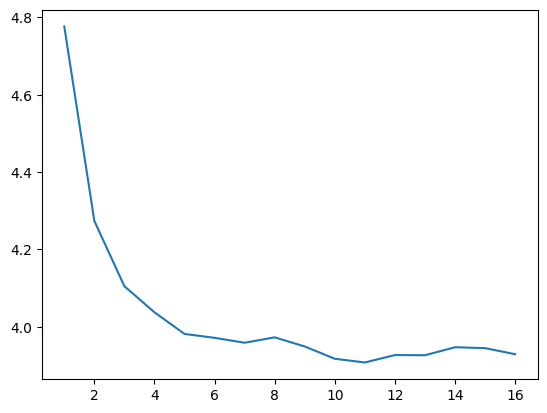

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [32]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')

## Predicción del próximo caracter

In [ ]:
#!pip install -q gradio

In [36]:
#import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

"""iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True) """

'iface = gr.Interface(\n    fn=model_response,\n    inputs=["textbox"],\n    outputs="text")\n\niface.launch(debug=True) '

In [42]:
print(model_response("Hola cómo est"))

1/1 [==============================] - 0s 30ms/step
Hola cómo esta


In [43]:
print(model_response("Hola cómo es"))

1/1 [==============================] - 0s 31ms/step
Hola cómo est


In [44]:
print(model_response("Imagin"))

1/1 [==============================] - 0s 31ms/step
Imagina


Según las pruebas realizadas arriba, el modelo está completando correctamente las palabras. La perplejidad obtenida también es buena, al estar por debajo de 4.

## Generación de secuencias

In [45]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [46]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habia una vez en cuanto a la señora bennet '

In [47]:
input_text='el sr bennet dijo'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'el sr bennet dijo el señor bennet por la carta '

Vemos que forma palabras que en individualmente están bien, incluso grupos de palabras que tienen sentino juntas como "la señora bennet". Sin embargo en el segundo ejemplo vemos repetición, y a la oración como total aún le falta sentido.

## Beam search y muestreo aleatorio

In [50]:
# Usamos las funciones creadas en el ejemplo de la cursada

# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="habia una vez")

In [51]:
# veamos las salidas
decode(salidas[0])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkhabia una vez que la señora benne'

In [52]:
decode(salidas[1])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkhabia una vez que la señorita bin'

In [53]:
# predicción con beam search
salidas_2 = beam_search(model,num_beams=10,num_words=20,input="el sr bennet dijo")

In [54]:
# veamos las salidas
decode(salidas_2[0])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkel sr bennet dijo la señorita bingley'

In [55]:
decode(salidas_2[1])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkel sr bennet dijo la señora bennet qu'

In [56]:
decode(salidas_2[2])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkel sr bennet dijo la señora bennet y '

In [57]:
# predicción con beam search
salidas_3 = beam_search(model,num_beams=10,num_words=20,input="el sr darcy era muy")

In [58]:
decode(salidas_3[0])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkel sr darcy era muy agradable que estab'

In [59]:
decode(salidas_3[1])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkel sr darcy era muy agradablemente con '

In [60]:
decode(salidas_3[2])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkel sr darcy era muy agradable que se ha'

In [65]:
salidas_est = beam_search(model,num_beams=10,num_words=20,input="el sr darcy era muy",temp=2,mode='sto')

In [66]:
decode(salidas_est[2])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkel sr darcy era muy bien se atención qu'

In [67]:
salidas_est_2 = beam_search(model,num_beams=10,num_words=20,input="el sr bennet dijo",temp=2,mode='sto')

In [71]:
decode(salidas_est_2[3])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkel sr bennet dijo su casa ni es las r'

In [72]:
salidas_est_3 = beam_search(model,num_beams=10,num_words=20,input="había una vez",temp=2,mode='sto')

In [74]:
decode(salidas_est_3[1])

'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkhabía una vez que estoy segura a '

Vemos que los resultados mejoran mucho con beam search, sobre todo en los ejemplos vistos tienen algo más de sentido al usar beam search determinista.No se observó tanta mejora con los modelos estocásticos, probando con temperatura 1 o 2.

Adicionalmente, observamos que el modelo ha aprendido correctamente los nombres de varios personajes como el Sr y Sra bennet, o la señorita Bingley.

En general, vemos mejores resultados que el modelo realizado en base a palabras. Si bien demoró un poco más el entrenamiento, el uso de memoria fue menor que al entrenar el modelo con palabras, ya que sí pudimos entrenar el modelo con toda la base de datos.